In [1]:
#Install Required Libraries
!pip install pandas prophet matplotlib scikit-learn

Packages

In [2]:
# Import necessary libraries
import pandas as pd
import itertools
import joblib
import os
from prophet import Prophet
from prophet.diagnostics import performance_metrics,cross_validation
from prophet.plot import plot_cross_validation_metric
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [11]:
from google.colab import files
from google.colab import drive

# Preprocessing functions

In [3]:
def run_preprocess(df):
  #convert date col
  df['Date'] = pd.to_datetime(df['Date'])
  #group by provided assets
  asset_data = df.groupby('Asset_ID')

  #storage data
  data_dict={}
  for asset_id, as_group in asset_data:
    print(f"processing asset: {asset_id}")
    #run all preprocessing steps:
    data = handle_missing_rows(start_date=df["Date"].min(), end_date=df["Date"].max(), df=df, col="Daily_mileage", approach="zero")
    outliers = identifiy_outliers(data)
    data = normalize_outliers(outliers = outliers,df=data, approach="prophet")
    data= transform_to_prophet_format(data)
    # TODO eventuell den split einbauen aber ich glaube das ist bullshit
    data_dict[asset_id]=data
  return data_dict


In [4]:
def transform_to_prophet_format(df, date_col = 'Date', dep_var = 'Daily_mileage'):
    # Prepare the training data for Prophet
    df = df.rename(columns={date_col: 'ds',  dep_var: 'y'})
    return df

In [5]:
def handle_missing_values(df, date_col = 'Date', col="Daily_mileage",approach="zero"): #TODO: anpassen ASSET ID soll weg


  if len(df[df[col].isnull()]) == 0:
    print("no missing values found")
    return df

  print(len(df[df[col].isnull()]))
  print("this is the input df for missing values")
  print(df.head())

  filled_df = df.copy()


  if approach == "zero":
      #fill missing values with zero, assuming that missing values indicate no vehicle activity
      filled_df[col].fillna(0,inplace=True)
  elif approach == "mean":
      #fill missing values with mean values for the vehicle
      filled_df[col].fillna(df[col].mean(),inplace=True)
  elif approach == "median":
      #fill missing values with median values for the vehicle
      filled_df[col].fillna(df[col].median(),inplace=True)
  elif approach == "interpolate":
      #fill missing values by interpolation
      filled_df[col].interpolate(inplace=True)
  elif approach == "prophet":
      #leave missing values as NaN values for prophet model
      pass

  missing=filled_df[df[col].isnull()]
  print(missing.head())


  plt.figure(figsize=(10, 5))
  #print original data and filled points
  plt.plot(df['Date'], df[col], label='Original',color='green' )
  plt.scatter(missing['Date'], missing[col], label='Filled_values', marker='o',color="red")
  plt.plot(filled_df['Date'], filled_df[col], label='Filled',color='blue')

  plt.title(f'Time Series Data filled with {approach} approach')
  plt.xlabel('Date')
  plt.ylabel('Daily_mileage')
  plt.legend()
  plt.show()


  return filled_df


In [6]:
def handle_missing_rows(start_date, end_date, df, col="Daily_mileage", approach="zero"):


  #create a range of all the dates between start and end date
  full_date_range = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq='D'), columns=['Date'])

  #right join to get missing dates
  merged_df = pd.merge(df,full_date_range, on='Date', how='right')
  merged_df["Asset_ID"] = df.Asset_ID.max()
  missing_rows = merged_df[merged_df[col].isnull()]

  print(f"dimensions: {len(merged_df)} and {len(df)}" )

  print(f"missing rows where identified:")
  print(missing_rows.head())
  return handle_missing_values(df=merged_df,col=col,approach=approach)


In [7]:
def identifiy_outliers(df):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
  Q1 = df["Daily_mileage"].quantile(0.25)
  Q3 = df["Daily_mileage"].quantile(0.75)
  IQR = Q3 - Q1

  # Define outlier bounds
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Identify outliers
  outliers = df[(df["Daily_mileage"] < lower_bound) | (df['Daily_mileage'] > upper_bound)]

  if outliers.empty:
    print("no outliers identified")
    return outliers

  #show outliers
  plt.figure(figsize=(10, 5))
  plt.plot(df['Date'], df["Daily_mileage"], label='Original', color='green' )
  plt.scatter(outliers['Date'], outliers["Daily_mileage"], label='Outliers', color="red" ,marker='o')
  #show quantils

  plt.axhline(y=Q1, color='blue', linestyle='--', label='Q1')
  plt.axhline(y=Q3, color='orange', linestyle='--', label='Q3')
  plt.axhline(y=lower_bound, color='red', linestyle='--', label='Lower Bound')
  plt.axhline(y=upper_bound, color='red', linestyle='--', label='Upper Bound')

  plt.title('Time Series Data Outliers')
  plt.xlabel('Date')
  plt.ylabel('Daily_mileage')
  plt.legend()
  plt.show()
  print(f"outliers where found {outliers}")
  return outliers


In [8]:
def normalize_outliers(df, outliers, col="Daily_mileage", approach="interpolate"):
  df.loc[df.index.isin(outliers.index),col] = np.nan
  print(f"this is the normalizer function: {approach}")
  return handle_missing_values(df=df, col=col, approach = approach)


In [9]:
#not used here
def split_train_test(df,date_col="Date", split_date= '2024-04-23'):
  train_data = df[df[date_col] < split_date]
  test_data = df[df[date_col] >= split_date]



We are not going to use this split here because we will use cross validation for evaluation instead

# Training  and Evaluation Functions

In [15]:
def run_training(data_dict,path=None):
  for asset_id,data in data_dict.items():
    best_params =hyperparam_tuning(data)
    model = train_prothet_model(data, hyperparameter=best_params)
    df_cv , df_p = evaluate_model(model,f"{asset_id}_model")
    save_model(model, f"{asset_id}_model")


In [16]:
def train_prothet_model(train_data, hyperparameter=None):

      # Initialize the Prophet model
      # Train final model with best parameters
      if hyperparameter:
        model = Prophet(**hyperparameter, weekly_seasonality=True, daily_seasonality=False)
      else:
        model = Prophet(weekly_seasonality=True, daily_seasonality=False)
      # Fit the model
      model.fit(train_data)
      return model


In [17]:
def evaluate_model(model,model_name, path=None):
    #241 Tage Das ist 7 Monate und 28 Tage
    df_cv = cross_validation(model,initial="120 days", period='2days' , horizon = '21 days')
    print("this is the output of the cross validation ")
    print(df_cv.head())

    #compute performance metrics
    df_p = performance_metrics(df_cv)
    df_p.head()

    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    fig.suptitle(model_name)

    if path:
    # Save the figure to a file
        os.makedirs(path, exist_ok=True)
        file_path = os.path.join(path, f'{model_name} RMSE')
        fig.savefig(file_path)
         # Save df_cv to an Excel file
        df_cv.to_excel(os.path.join(path, f'{model_name}_CR'), sheet_name='Cross_Validation {model_name}', index=False)
      # Save df_p
        df_p.to_excel(os.path.join(path, f'{model_name}_Performance'), sheet_name='Performance_Metrics {model_name}', index=False)

    return df_p, df_cv


In [20]:
def hyperparam_tuning(train_data, metric='rmse', horizon = '21 days'):
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
      'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
  }

  # Generate all combinations of parameters
  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []  # Store the RMSEs for each params here

  # Use cross validation to evaluate all parameters
  for params in all_params:
      m = Prophet(**params).fit(train_data)  # Fit model with given params with our chosen processed data
      df_cv = cross_validation(m, horizon=horizon, parallel="processes")
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p[metric].values[0])

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results[metric] = rmses
  best_params = all_params[tuning_results[metric].idxmin()]

  return best_params

# Model handeling functions

In [18]:
def save_model(model, model_name, path=None):
  # Save the model to a file
  if path:
    # Ensure the path directory exists
        os.makedirs(path, exist_ok=True)
        file_path = os.path.join(path, f'{model_name}.pkl')
  else:
    file_path = f'{model_name}.pkl'
  joblib.dump(value= model, filename=file_path)

# EDA

In [ ]:

drive.mount('/content/drive')
path = "/content/drive/My Drive/data/taxi-pipeline-data/Dataset_Daily_mileage.csv"

df = pd.read_csv(path,sep = ',', encoding="utf-8-sig")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'])

asset_data = df.groupby('Asset_ID')
# Display the DataFrame
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01              0
1   1051822 2023-09-01             39
2   1036708 2023-09-02             22
3   1051822 2023-09-02             30
4   1036708 2023-09-03              0


In [ ]:
asset_id, group = next(iter(df.groupby('Asset_ID')))
group.head()


,Asset_ID,Date,Daily_mileage
0,1036708,2023-09-01,0
2,1036708,2023-09-02,22
4,1036708,2023-09-03,0
6,1036708,2023-09-04,0
8,1036708,2023-09-05,11


In [ ]:
group.describe()

,Asset_ID,Date,Daily_mileage
count,193.0,193,193.000000
mean,1036708.0,2023-12-18 09:41:58.134715136,14.010363
min,1036708.0,2023-09-01 00:00:00,0.000000
25%,1036708.0,2023-10-21 00:00:00,0.000000
50%,1036708.0,2023-12-09 00:00:00,5.000000
75%,1036708.0,2024-01-26 00:00:00,18.000000
max,1036708.0,2024-04-29 00:00:00,120.000000
std,0.0,NaN,22.399542


Text(0.5, 1.0, 'Daily_mileage')

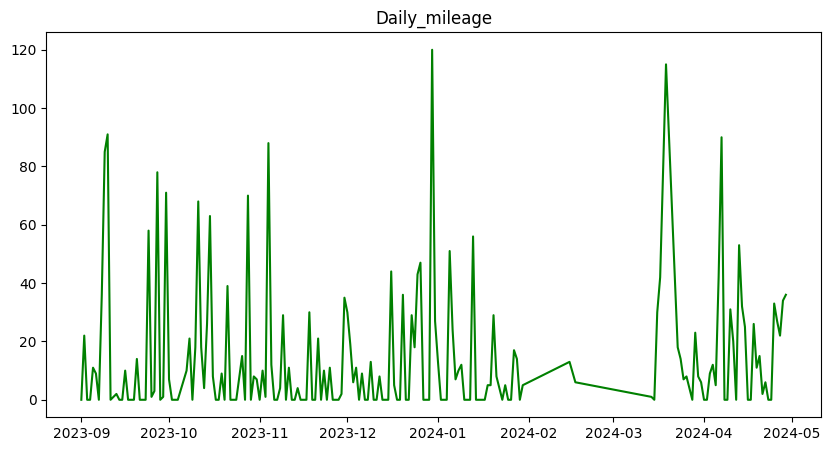

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(group['Date'], group["Daily_mileage"], label='daily mileage',color='green' )
plt.title('Daily_mileage')


Take a closer look at what happens in febuary and march 2024

In [ ]:
group.loc[group["Date"].isin(["02.04.2024","03.04.2024"])]

,Asset_ID,Date,Daily_mileage


missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05       3.333333
35    1036708 2023-10-06       6.666667
54    1036708 2023-10-25       7.500000
152   1036708 2024-01-31       5.500000
153   1036708 2024-02-01       6.000000


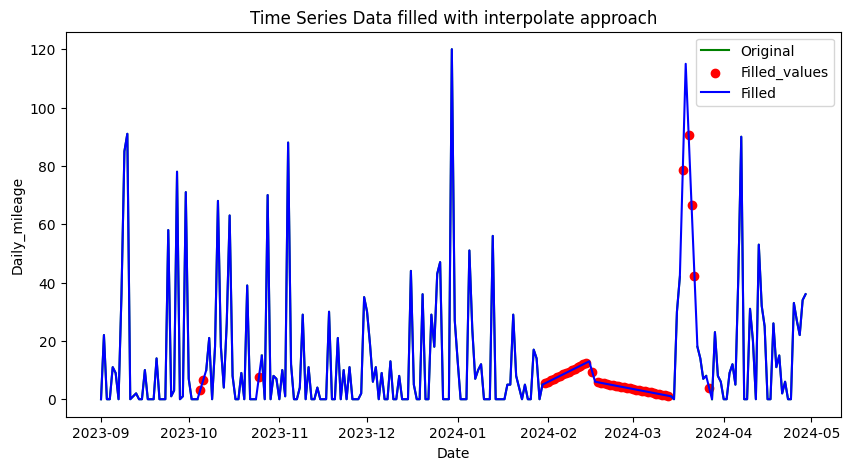

In [ ]:
interpolated = handle_missing_rows(group.Date.min(),group.Date.max(), group, approach="interpolate")


the output is the same, which is sensible as an interpolation by default is done lineary, so it will just connect connect the last to available datapoints lineary in case of missing values.
We will now see if the plot changes when we choose to set missing values to zero.

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            0.0
35    1036708 2023-10-06            0.0
54    1036708 2023-10-25            0.0
152   1036708 2024-01-31            0.0
153   1036708 2024-02-01            0.0


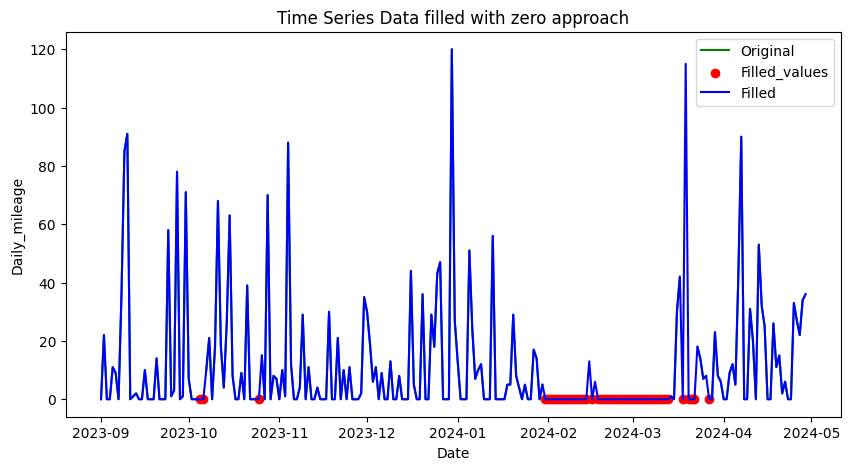

In [ ]:
set_zero = handle_missing_rows(group.Date.min(),group.Date.max(), group, approach="zero")


We see now that the data in febuary and march was missing.

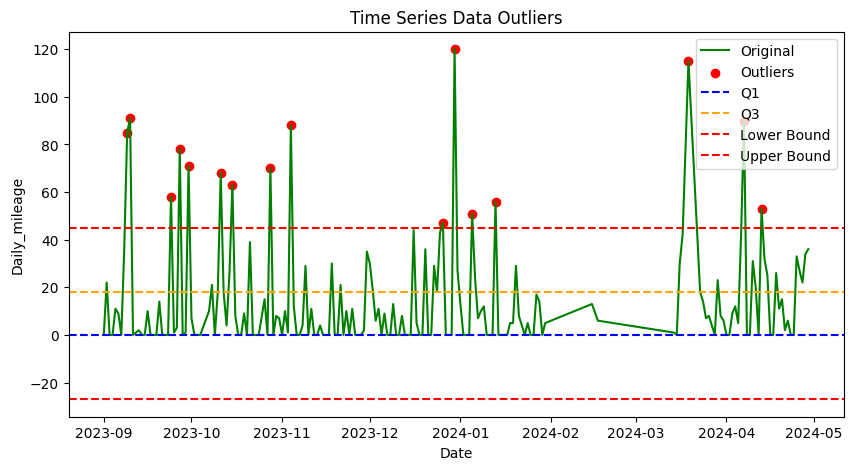

outliers where found      Asset_ID       Date  Daily_mileage
16    1036708 2023-09-09             85
18    1036708 2023-09-10             91
46    1036708 2023-09-24             58
52    1036708 2023-09-27             78
58    1036708 2023-09-30             71
78    1036708 2023-10-11             68
86    1036708 2023-10-15             63
111   1036708 2023-10-28             70
125   1036708 2023-11-04             88
229   1036708 2023-12-26             47
237   1036708 2023-12-30            120
249   1036708 2024-01-05             51
265   1036708 2024-01-13             56
338   1036708 2024-03-19            115
372   1036708 2024-04-07             90
384   1036708 2024-04-13             53


,Asset_ID,Date,Daily_mileage
16,1036708,2023-09-09,85
18,1036708,2023-09-10,91
46,1036708,2023-09-24,58
52,1036708,2023-09-27,78
58,1036708,2023-09-30,71
78,1036708,2023-10-11,68
86,1036708,2023-10-15,63
111,1036708,2023-10-28,70
125,1036708,2023-11-04,88
229,1036708,2023-12-26,47


In [ ]:
identifiy_outliers(group)

In [ ]:
#explore missing values
len(df[df['Daily_mileage'].isnull()])

0

## Chose a method to handle missing values

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            0.0
35    1036708 2023-10-06            0.0
54    1036708 2023-10-25            0.0
152   1036708 2024-01-31            0.0
153   1036708 2024-02-01            0.0


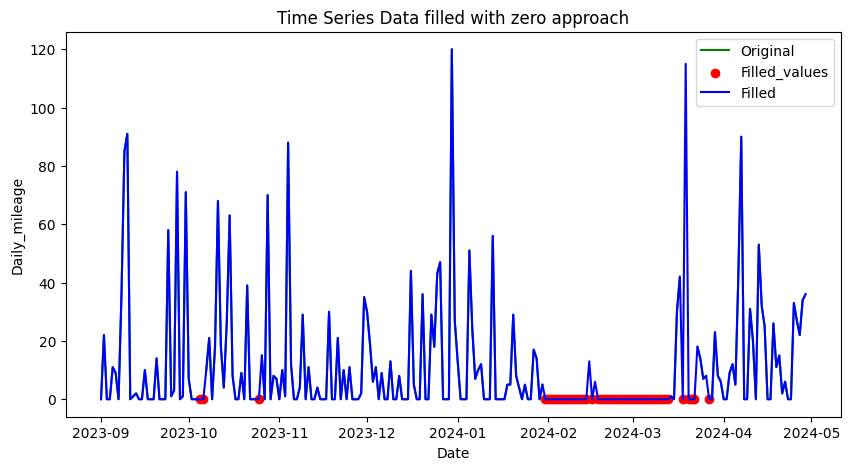

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05       3.333333
35    1036708 2023-10-06       6.666667
54    1036708 2023-10-25       7.500000
152   1036708 2024-01-31       5.500000
153   1036708 2024-02-01       6.000000


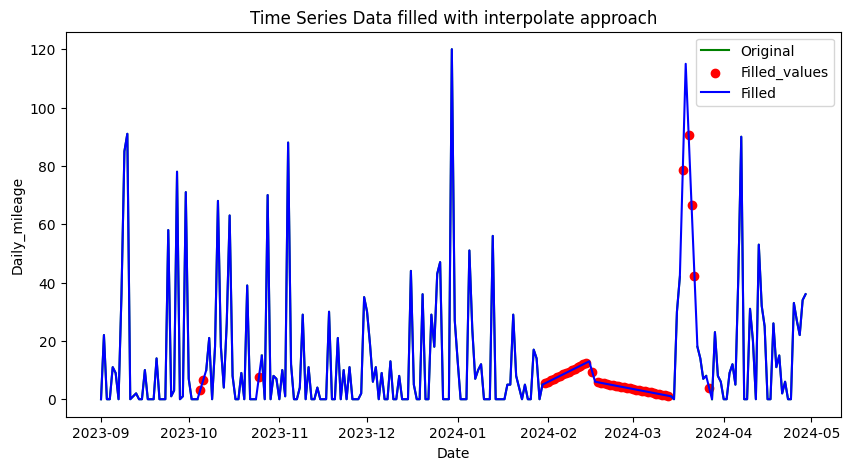

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05      14.010363
35    1036708 2023-10-06      14.010363
54    1036708 2023-10-25      14.010363
152   1036708 2024-01-31      14.010363
153   1036708 2024-02-01      14.010363


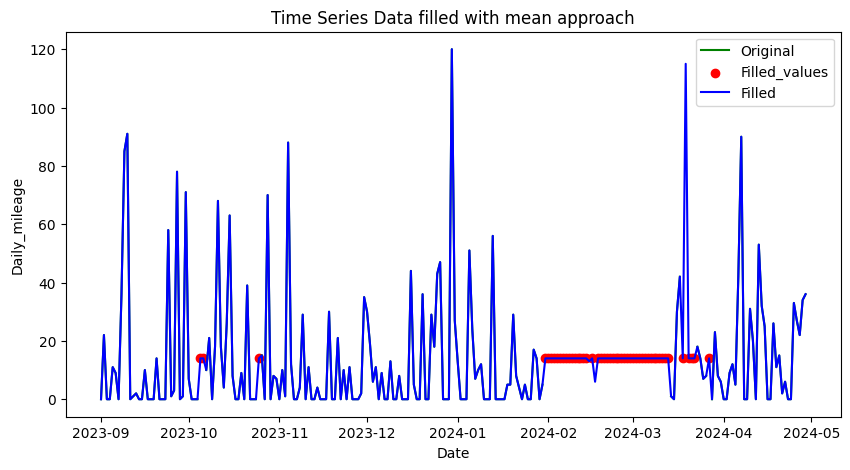

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            5.0
35    1036708 2023-10-06            5.0
54    1036708 2023-10-25            5.0
152   1036708 2024-01-31            5.0
153   1036708 2024-02-01            5.0


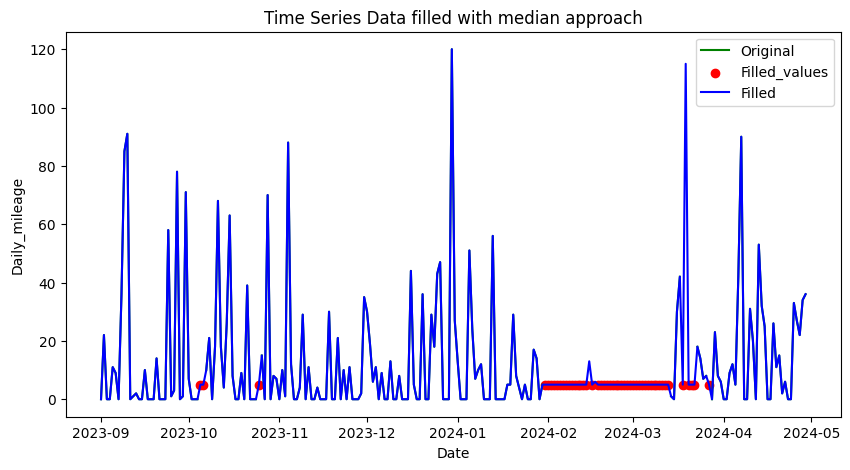

missing rows where identified:
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN
49
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1036708 2023-09-01            0.0
1   1036708 2023-09-02           22.0
2   1036708 2023-09-03            0.0
3   1036708 2023-09-04            0.0
4   1036708 2023-09-05           11.0
     Asset_ID       Date  Daily_mileage
34    1036708 2023-10-05            NaN
35    1036708 2023-10-06            NaN
54    1036708 2023-10-25            NaN
152   1036708 2024-01-31            NaN
153   1036708 2024-02-01            NaN


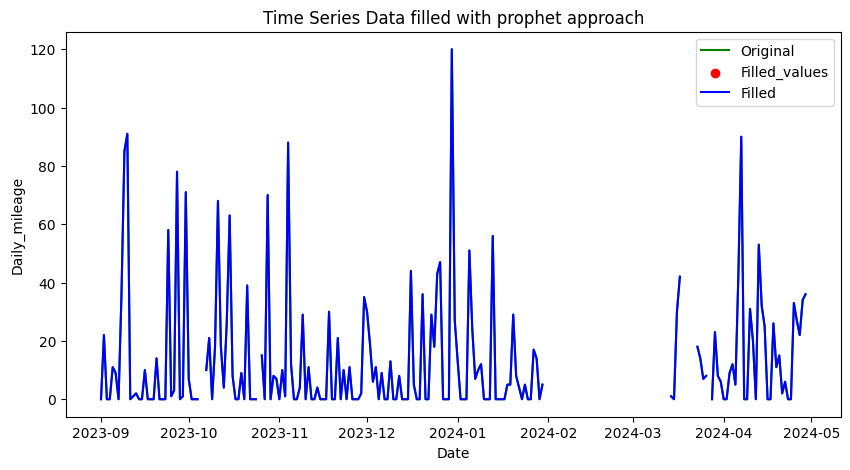

In [ ]:
#try out the different ways of handeling missing values and transform them to prohet input format
data_zero = transform_to_prophet_format(handle_missing_rows(start_date=group["Date"].min(), end_date=group["Date"].max(), df=group, approach="zero"))
data_inter = transform_to_prophet_format(handle_missing_rows(group["Date"].min(), group["Date"].max(), group, approach="interpolate"))
data_mean = transform_to_prophet_format(handle_missing_rows(group["Date"].min(), group["Date"].max(), group, approach="mean"))
data_median = transform_to_prophet_format(handle_missing_rows(group["Date"].min(), group["Date"].max(), group, approach="median"))
data_prophet = transform_to_prophet_format(handle_missing_rows(group["Date"].min(), group["Date"].max(), group, approach="prophet"))




In [ ]:
model_zero = train_prothet_model(asset_id=asset_id,train_data=data_zero)
model_inter = train_prothet_model(asset_id,data_inter)
model_mean = train_prothet_model(asset_id,data_mean)
model_median = train_prothet_model(asset_id,data_median)
model_prohet = train_prothet_model(asset_id,data_prophet)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/wvup3kgp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/ks3e9y5k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98256', 'data', 'file=/tmp/tmpuzhrcwde/wvup3kgp.json', 'init=/tmp/tmpuzhrcwde/ks3e9y5k.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_model9v7y4upz/prophet_model-20240529134103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:41:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:41:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/4ukmrva1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/7gvg0j33.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

INFO:prophet:Making 51 forecasts with cutoffs between 2023-12-30 00:00:00 and 2024-04-08 00:00:00


  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/436ouc8v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/xf27v5lo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34130', 'data', 'file=/tmp/tmpuzhrcwde/436ouc8v.json', 'init=/tmp/tmpuzhrcwde/xf27v5lo.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_modelek_9nhr4/prophet_model-20240529140847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:08:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:08:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/47dtkabv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/o5fn5jbn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  52.019410   28.760370   77.040559  27.0 2023-12-30
1 2024-01-01  44.710247   19.731494   67.937495  13.0 2023-12-30
2 2024-01-02  53.024772   28.319693   76.394201   0.0 2023-12-30
3 2024-01-03  64.457154   41.703800   90.203644   0.0 2023-12-30
4 2024-01-04  64.236383   39.489823   87.041209   0.0 2023-12-30


  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/bzgwppt_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/k64r0x7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=84098', 'data', 'file=/tmp/tmpuzhrcwde/bzgwppt_.json', 'init=/tmp/tmpuzhrcwde/k64r0x7e.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_modelcpk06ywe/prophet_model-20240529140902.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/bdrd30ft.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/peed7je3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  52.028750   28.365581   77.553697  27.0 2023-12-30
1 2024-01-01  44.722352   20.470147   70.372335  13.0 2023-12-30
2 2024-01-02  53.068370   29.243303   77.270167   0.0 2023-12-30
3 2024-01-03  65.377567   41.333748   90.228173   0.0 2023-12-30
4 2024-01-04  65.178254   40.438542   90.882692   0.0 2023-12-30


  0%|          | 0/39 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/a1lbh48m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/88u_2471.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81886', 'data', 'file=/tmp/tmpuzhrcwde/a1lbh48m.json', 'init=/tmp/tmpuzhrcwde/88u_2471.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_models0_vd87z/prophet_model-20240529140916.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/4ds0q6d8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/m79vrvsj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  51.320570   27.472591   77.060963  27.0 2023-12-30
1 2024-01-01  44.009024   18.717056   68.017079  13.0 2023-12-30
2 2024-01-02  52.223224   26.410328   74.383891   0.0 2023-12-30
3 2024-01-03  64.473189   40.388814   89.634744   0.0 2023-12-30
4 2024-01-04  64.032673   38.167440   88.844246   0.0 2023-12-30


INFO:prophet:Making 51 forecasts with cutoffs between 2023-12-30 00:00:00 and 2024-04-08 00:00:00


  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/e6lmqkvr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/g0uepyqv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30567', 'data', 'file=/tmp/tmpuzhrcwde/e6lmqkvr.json', 'init=/tmp/tmpuzhrcwde/g0uepyqv.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_modelz2zymlk8/prophet_model-20240529140926.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/howa3t7j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/p2yzktwg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  51.998515   28.979594   75.524679  27.0 2023-12-30
1 2024-01-01  44.712499   20.347242   68.059597  13.0 2023-12-30
2 2024-01-02  53.074950   28.702528   75.616911   0.0 2023-12-30
3 2024-01-03  64.853284   40.028775   87.232446   0.0 2023-12-30
4 2024-01-04  64.668619   39.109988   88.970041   0.0 2023-12-30


  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/lh9_kaq7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/fezjmby1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11866', 'data', 'file=/tmp/tmpuzhrcwde/lh9_kaq7.json', 'init=/tmp/tmpuzhrcwde/fezjmby1.json', 'output', 'file=/tmp/tmpuzhrcwde/prophet_model8diu0fqp/prophet_model-20240529140940.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:09:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:09:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/493ick42.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpuzhrcwde/0_c8klvu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  52.273754   29.295043   77.989881  27.0 2023-12-30
1 2024-01-01  45.082343   19.725684   69.348380  13.0 2023-12-30
2 2024-01-02  53.360565   29.257945   76.135320   0.0 2023-12-30
3 2024-01-03  65.163031   39.301427   88.660857   0.0 2023-12-30
4 2024-01-04  64.748071   42.714964   89.399225   0.0 2023-12-30


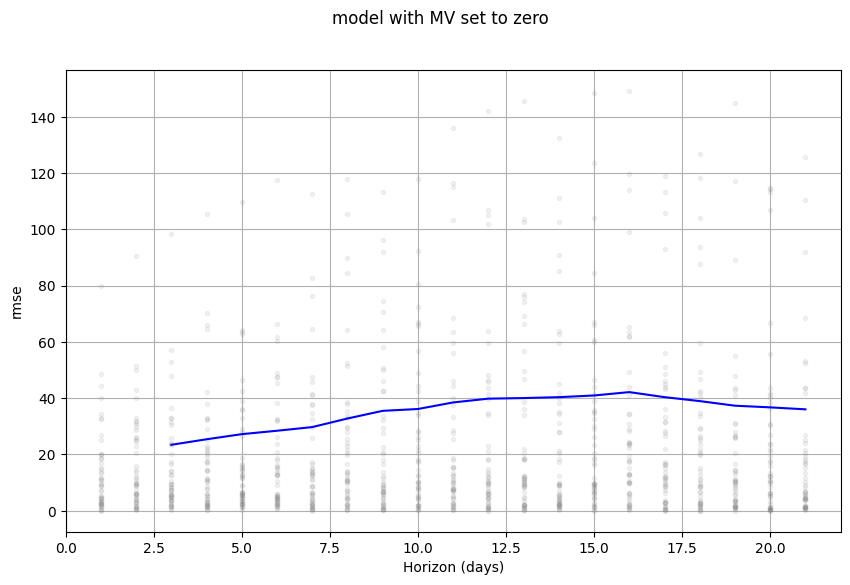

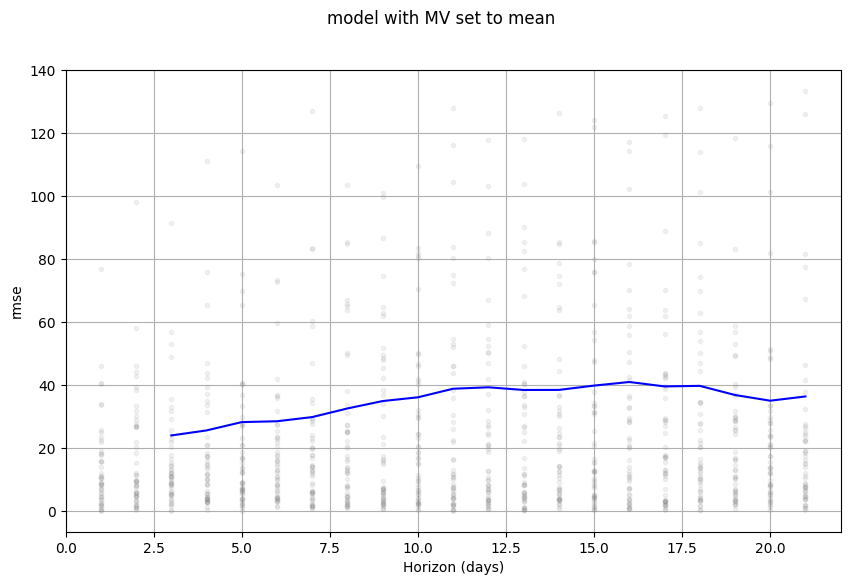

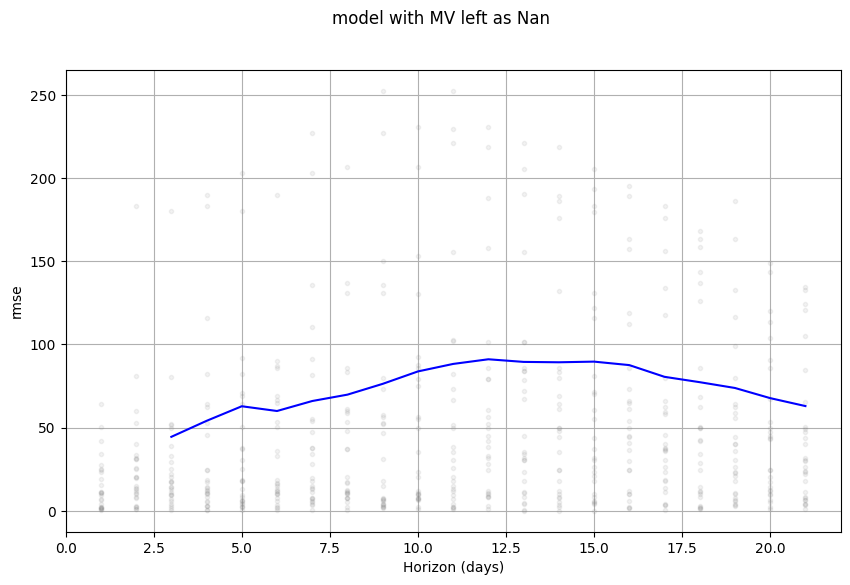

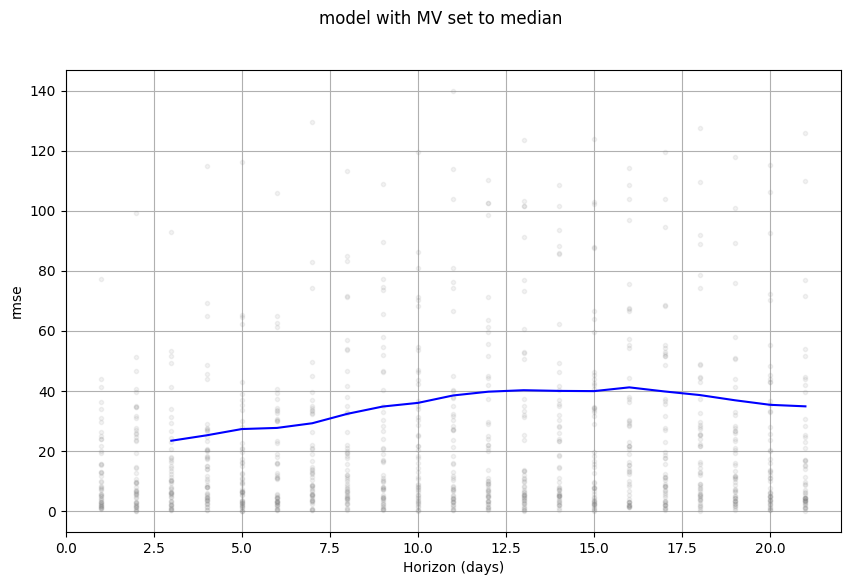

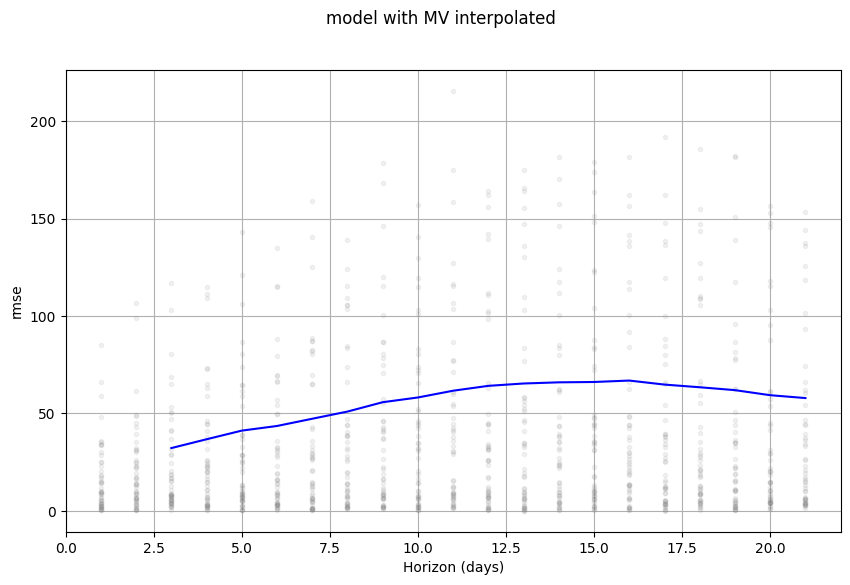

In [ ]:
eval_zero = evaluate_model(model_zero, "model with MV set to zero")
eval_mean = evaluate_model(model_mean, "model with MV set to mean")
eval_propghet = evaluate_model(model_prohet, "model with MV left as Nan")
eval_median=evaluate_model(model_median, "model with MV set to median")
eval_inter= evaluate_model(model_inter, "model with MV interpolated")


In [ ]:
print(eval_zero[0].head())

  horizon         mse       rmse        mae  mdape     smape  coverage
0  3 days  549.442327  23.440186  15.578781    inf  1.691399  0.730071
1  4 days  645.320315  25.403156  16.429979    inf  1.726364  0.743266
2  5 days  741.103582  27.223218  17.516579    inf  1.730709  0.745098
3  6 days  808.419122  28.432712  18.258401    inf  1.728013  0.745098
4  7 days  884.065639  29.733241  18.876033    inf  1.754737  0.735752


We can see that the model does best on data that is or set to the median or to zero. Since I assume missing rows indicate no vehicle activity, I will chose to proceed with the missing values set to zero.

# Preprocessing

In [12]:
drive.mount('/content/drive')
path = "/content/drive/My Drive/data/taxi-pipeline-data/Dataset_Daily_mileage.csv"

df = pd.read_csv(path,sep = ',', encoding="utf-8-sig")
print(df.head())

Mounted at /content/drive
   Asset_ID           Date  Daily_mileage
0   1036708  9/1/2023 0:00              0
1   1051822  9/1/2023 0:00             39
2   1036708  9/2/2023 0:00             22
3   1051822  9/2/2023 0:00             30
4   1036708  9/3/2023 0:00              0


processing asset: 1036708
dimensions: 435 and 418
missing rows where identified:
     Asset_ID       Date  Daily_mileage
303   1051822 2024-02-02            NaN
304   1051822 2024-02-03            NaN
305   1051822 2024-02-04            NaN
307   1051822 2024-02-06            NaN
308   1051822 2024-02-07            NaN
17
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1051822 2023-09-01            0.0
1   1051822 2023-09-01           39.0
2   1051822 2023-09-02           22.0
3   1051822 2023-09-02           30.0
4   1051822 2023-09-03            0.0
     Asset_ID       Date  Daily_mileage
303   1051822 2024-02-02            0.0
304   1051822 2024-02-03            0.0
305   1051822 2024-02-04            0.0
307   1051822 2024-02-06            0.0
308   1051822 2024-02-07            0.0


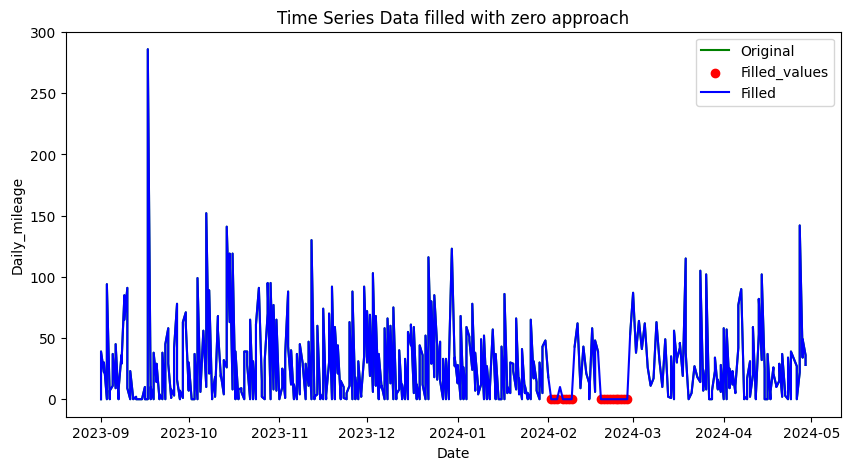

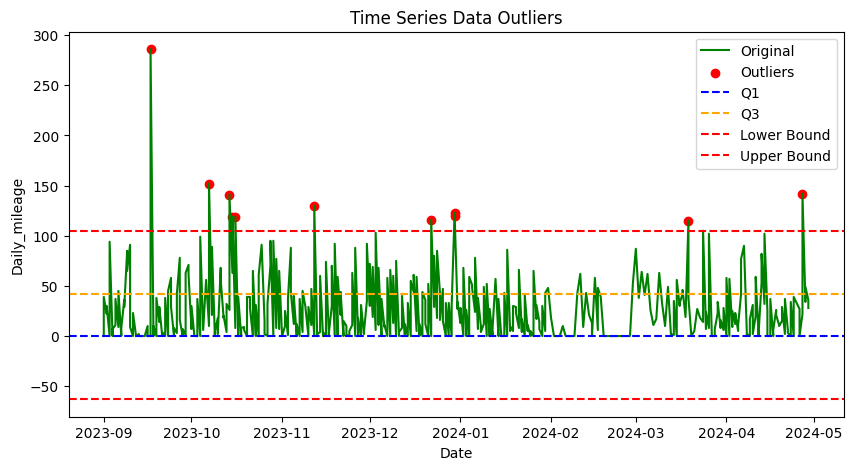

outliers where found      Asset_ID       Date  Daily_mileage
33    1051822 2023-09-17          286.0
71    1051822 2023-10-07          152.0
85    1051822 2023-10-14          141.0
87    1051822 2023-10-15          119.0
89    1051822 2023-10-16          119.0
142   1051822 2023-11-12          130.0
222   1051822 2023-12-22          116.0
237   1051822 2023-12-30          120.0
238   1051822 2023-12-30          123.0
355   1051822 2024-03-19          115.0
430   1051822 2024-04-27          142.0
this is the normalizer function: prophet
11
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1051822 2023-09-01            0.0
1   1051822 2023-09-01           39.0
2   1051822 2023-09-02           22.0
3   1051822 2023-09-02           30.0
4   1051822 2023-09-03            0.0
    Asset_ID       Date  Daily_mileage
33   1051822 2023-09-17            NaN
71   1051822 2023-10-07            NaN
85   1051822 2023-10-14            NaN
87   1051822 2023-10-15        

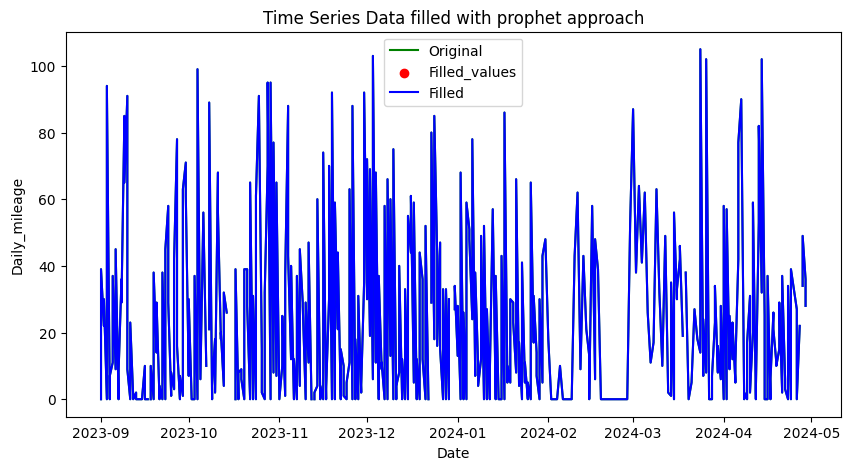

processing asset: 1051822
dimensions: 435 and 418
missing rows where identified:
     Asset_ID       Date  Daily_mileage
303   1051822 2024-02-02            NaN
304   1051822 2024-02-03            NaN
305   1051822 2024-02-04            NaN
307   1051822 2024-02-06            NaN
308   1051822 2024-02-07            NaN
17
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1051822 2023-09-01            0.0
1   1051822 2023-09-01           39.0
2   1051822 2023-09-02           22.0
3   1051822 2023-09-02           30.0
4   1051822 2023-09-03            0.0
     Asset_ID       Date  Daily_mileage
303   1051822 2024-02-02            0.0
304   1051822 2024-02-03            0.0
305   1051822 2024-02-04            0.0
307   1051822 2024-02-06            0.0
308   1051822 2024-02-07            0.0


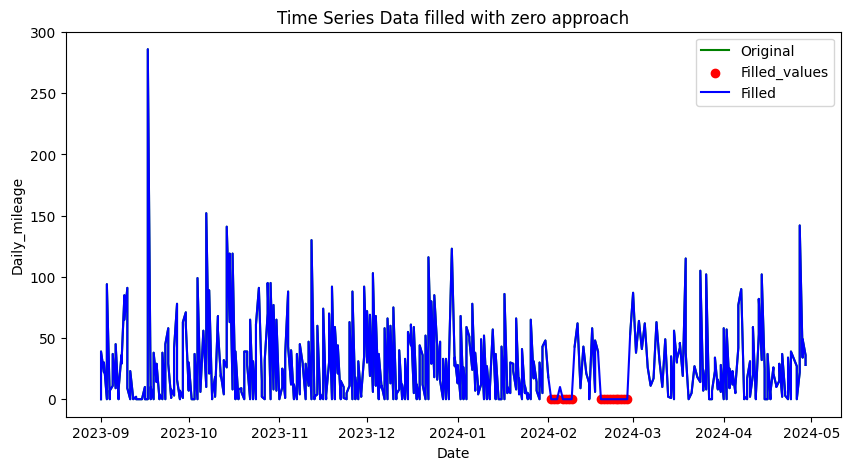

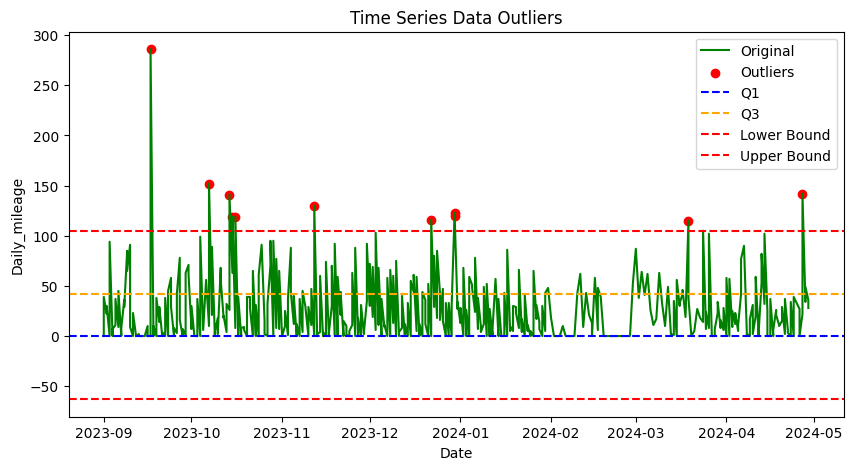

outliers where found      Asset_ID       Date  Daily_mileage
33    1051822 2023-09-17          286.0
71    1051822 2023-10-07          152.0
85    1051822 2023-10-14          141.0
87    1051822 2023-10-15          119.0
89    1051822 2023-10-16          119.0
142   1051822 2023-11-12          130.0
222   1051822 2023-12-22          116.0
237   1051822 2023-12-30          120.0
238   1051822 2023-12-30          123.0
355   1051822 2024-03-19          115.0
430   1051822 2024-04-27          142.0
this is the normalizer function: prophet
11
this is the input df for missing values
   Asset_ID       Date  Daily_mileage
0   1051822 2023-09-01            0.0
1   1051822 2023-09-01           39.0
2   1051822 2023-09-02           22.0
3   1051822 2023-09-02           30.0
4   1051822 2023-09-03            0.0
    Asset_ID       Date  Daily_mileage
33   1051822 2023-09-17            NaN
71   1051822 2023-10-07            NaN
85   1051822 2023-10-14            NaN
87   1051822 2023-10-15        

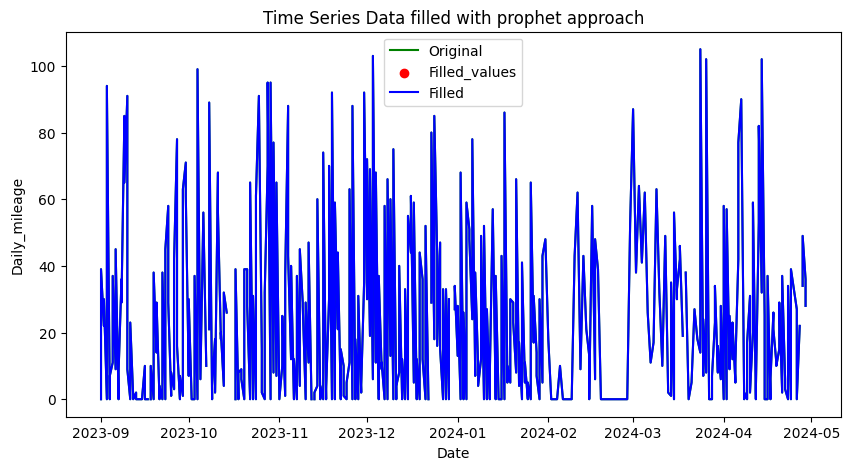

In [13]:
res_dict = run_preprocess(df)

# Model Training, Hyperparameter Tuning and Model Saving

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/m5_b0qjo.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/12bthui3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12470', 'data', 'file=/tmp/tmpune3nyyh/m5_b0qjo.json', 'init=/tmp/tmpune3nyyh/12bthui3.json', 'output', 'file=/tmp/tmpune3nyyh/prophet_model424ukx72/prophet_model-20240530201113.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:11:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:11:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cu

  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/cm1i4zt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/utomip06.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77532', 'data', 'file=/tmp/tmpune3nyyh/cm1i4zt4.json', 'init=/tmp/tmpune3nyyh/utomip06.json', 'output', 'file=/tmp/tmpune3nyyh/prophet_modelbyl5ugxv/prophet_model-20240530201245.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:12:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/_k1y8gs4.json
DE

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  42.766281    9.018739   78.751346  27.0 2023-12-30
1 2023-12-31  42.766281   10.538955   75.793794  34.0 2023-12-30
2 2024-01-01  17.264613  -16.472500   48.853633  13.0 2023-12-30
3 2024-01-01  17.264613  -15.671705   51.373371  28.0 2023-12-30
4 2024-01-02  26.045998   -8.044816   61.848908   0.0 2023-12-30


20:13:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 15 forecasts with cutoffs between 2023-11-13 00:00:00 and 2024-04-08 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x791f1669ebf0>
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/5hw9q4g1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/qs09iqas.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/k3aju3hf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/cu52ulvq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74242', 'data', 'file=/tmp/tmpune3nyyh/qs09iqas.json', 'init=/tmp/tmpune3nyyh/cu52ulvq.json', 'output', 'file=/tmp/tmpune3nyyh/prophet_modelbau37cpm/prophet_model-2024

  0%|          | 0/51 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/zq3s92q0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/g23e95mk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9702', 'data', 'file=/tmp/tmpune3nyyh/zq3s92q0.json', 'init=/tmp/tmpune3nyyh/g23e95mk.json', 'output', 'file=/tmp/tmpune3nyyh/prophet_model6u_sfuwd/prophet_model-20240530201524.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:15:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmpune3nyyh/vp22buqr.json
DEB

this is the output of the cross validation 
          ds       yhat  yhat_lower  yhat_upper     y     cutoff
0 2023-12-31  42.766281   10.394240   76.438612  27.0 2023-12-30
1 2023-12-31  42.766281   10.184694   76.947112  34.0 2023-12-30
2 2024-01-01  17.264613  -18.410827   51.268386  13.0 2023-12-30
3 2024-01-01  17.264613  -15.472346   52.305481  28.0 2023-12-30
4 2024-01-02  26.045998   -7.432625   59.276202   0.0 2023-12-30


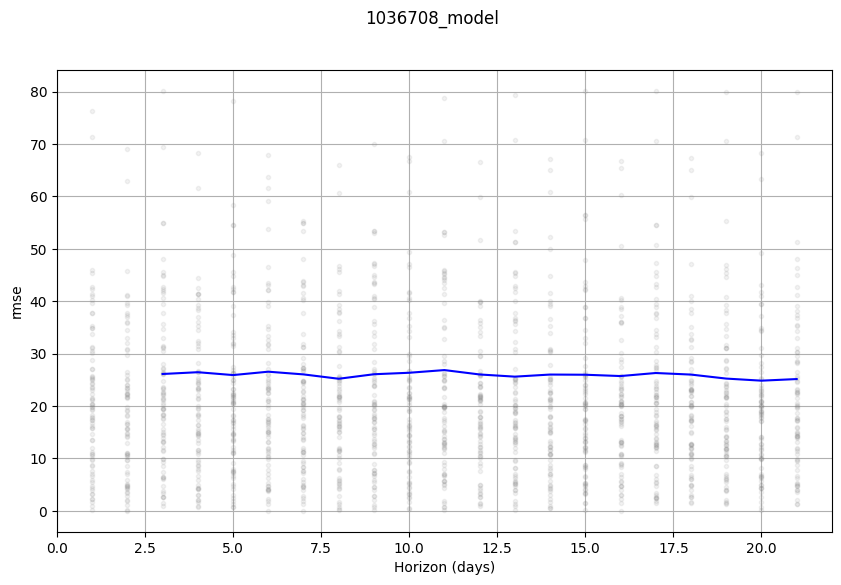

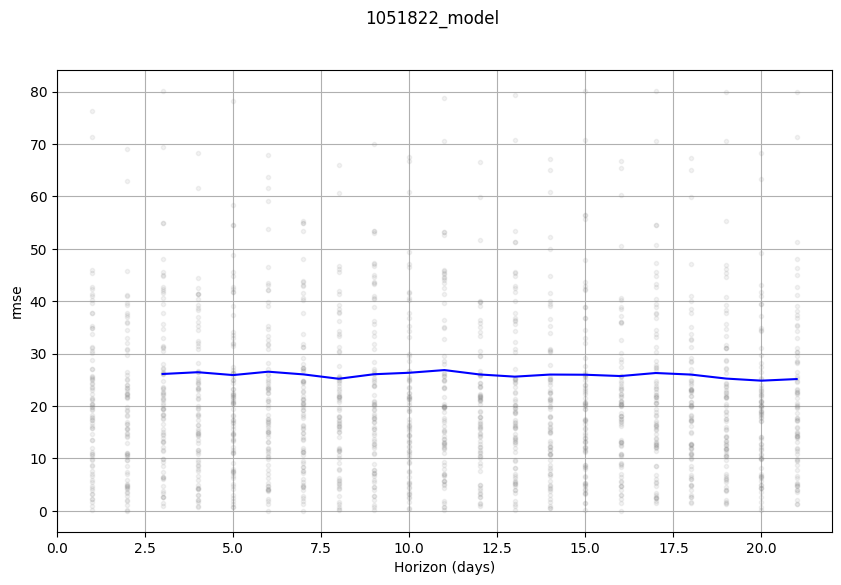

In [22]:
run_training(res_dict)

We will chose the hyperparameter with the lowest RMSE and save the model